# Unit 2 Portfolio Project
## Predictive Modeling with Spotify Data
Ryan Fikejs - *Data Science, Lambda School DS 26*

### Build Week Day 2 (v2.1.1)

*Try the split using time series*

tried a few different splits for to see if that helped efficacy

Notes:

• Decided to likely stick with random train test split

• Will attempt again after new feature is engineered and

adopted from 2.1.0 

• 

• 

### Build Week Day 1 (v2.0)

*Use Pandas Profiling to get a bigger picture of what we're dealing with*



*Make a linear model for comparison.*



*Do some hyper parameter tuning*



*Engineer an 'age' feature, or test with 'realease_date' back intact*



*Process oridnally encode artists id column such that Shaply force plot will work*



Notes:

• Attempted a brief experiemnt with costcla Cost Classifier, but

importing failed because a support package in sklearn.exernals

was not found. 

• Attempted to use costsensitive package

• Split into version 2.0.1 which was a more focused dataset whose

observations had high danceability

• 

### Module 4 Tasks (v1.3)

*Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.*



*Make at least 1 partial dependence plot to explain your model.*



*Make at least 1 Shapley force plot to explain an individual prediction.*



*Share at least 1 visualization (of any type) on Slack!*



Notes:

• Trimmed data set down to the past 50 years

• Hypertuned some parameters

• Dropped some columns for minimal impact on target as informed by 
the permutation importances

### Module 3 Tasks (v1.2)

*Continue to clean and explore your data. Make exploratory visualizations*



*Fit a model. Does it beat your baseline?*

Yes.

*Try XGBoost*

Didn't perform as well on first run, but I will take out some features and do some more tuning.

*Get your model's permutation importances.*


**Notes:**

• Added <inplace=True> to the part of the wrangle function dropping 'popularity' feature 

• Considering looking at releases from the past 20 - 50 years as I think that would still be a relevant set of data to learn from.

### Module 2 Tasks (v1.1)

*Continue to clean and explore your data.*

Data is very clean, but I did decide on a few columns to create and drop.

*For the evaluation metric you chose, what score would you get just by guessing?*

For this afternoon I just went ahead with the accuracy score, but tonight I will experiment with others.

*Can you make a fast, first model that beats guessing?*

I did, but it may be too good. Further investigating tonight


**Notes:**

• I did change my target array to five classes / buckets (100+ is too many for what I'm trying to do)

• I may change my target to a binary classification

• I may consider trying to do this task for a more specific genre in order to work with a smaller data set.

### Module 1 Tasks

*Choose your target. Which column in your tabular dataset will you predict?*

My target is the popularity rating.

*Is your problem regression or classification?*

Currently considering it a large scale classification problem, (there are 101 classes involved) wondering if I should cut it down as was done in the burrito problem and say a popularity rating of 80-100 is very popular, below 80 is not very popular.

*How is your target distributed?*

*Classification: How many classes? Are the classes imbalanced?*

101 classes very imbalanced.

*Choose your evaluation metric(s).*

*Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that 
range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?*

No, I will likely be using F1-score and AUC of ROC. (Maybe categorical crossentropy if I learn enough about it and it makes sense to, I heard it's good for generalizing multiclass problems, but is typically used with neural networks.)

*Choose which observations you will use to train, validate, and test your model.*

I will use a random selection via train test split to separate atraining set and cross validation for training and validation.

*Are some observations outliers? Will you exclude them?*

No

*Will you do a random split or a time-based split?*

Random split

*Begin to clean and explore your data.*

*Begin to choose which features, if any, to exclude. Would some features "leak" future information?*

I will leave out song ID and name. I may keep either artists or id_artists.

## I. Wrangle Data

### Import packages

In [3]:
# For data frame manipulation
import pandas as pd

# For more math horsepower
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For exploratory data analysis / profiling
from pandas_profiling import ProfileReport

# For pipeline and model building
# Pipeline
from sklearn.pipeline import make_pipeline
# Transformers
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
# For random forest
from sklearn.ensemble import RandomForestClassifier
# For gradient boost
from xgboost import XGBClassifier
# For splitting data, scoring, tuning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# For scoring and evaluating results
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
# For determining most important features
from sklearn.inspection import permutation_importance

# For demostrating partial dependencies of the target on
# specific features 
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot 

# For cost-sensitive classification
import costsensitive

# For displaying a Shaply force plot
import shap

## Wrangle Data

In [15]:
def wrangle(file_path):
    df = pd.read_csv(file_path,
                    parse_dates=['release_date'])
    
    # Split release_date into day, month, year, then drop it
    df['released_year'] = df['release_date'].dt.year
#     df['released_month'] = df['release_date'].dt.month
#     df['released_day'] = df['release_date'].dt.day
    df.set_index('release_date', inplace=True)
    
    # Make new buckets for prediction
    df['popular'] = [0 if r<19 else 1 if r<39 else 2 if r<59 else 3 if r<79 else 4 for r in df['popularity']]
    df.drop(columns='popularity', inplace=True)
    
    # Drop columns I suspect do not imfluence the target, or are redundant
    df.drop(columns=['id', 'name', 'artists'], inplace=True)
    
    # Limit the data set to the past 50 years
    df = df[df['released_year'] >= 1971]
    
    # Drop columns that were determined to have least importance
    # in my permutation importances below
    df.drop(columns=['key', 'time_signature', 'mode', 'tempo',
                     'valence', 'liveness', 'speechiness',
                     'danceability', 'explicit'],
                    inplace=True)
    
    return df

In [16]:
df = wrangle('data/tracks.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459751 entries, 2008-02-11 to 2015-07-01
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       459751 non-null  int64  
 1   id_artists        459751 non-null  object 
 2   energy            459751 non-null  float64
 3   loudness          459751 non-null  float64
 4   acousticness      459751 non-null  float64
 5   instrumentalness  459751 non-null  float64
 6   released_year     459751 non-null  int64  
 7   popular           459751 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 31.6+ MB


1    195815
2    131786
0    101512
3     29422
4      1216
Name: popular, dtype: int64


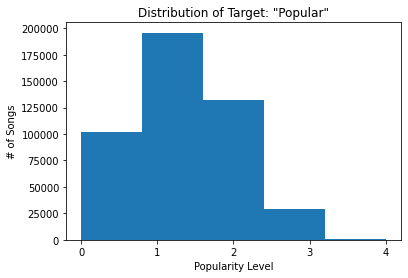

In [11]:
# Look at the distribution of the target
class_dist = df['popular']
print(class_dist.value_counts())
plt.hist(class_dist, bins=5)
plt.xticks((0, 1, 2, 3, 4))
plt.xlabel('Popularity Level')
plt.ylabel('# of Songs')
plt.title('Distribution of Target: "Popular"')
plt.show()

In [38]:
# Get a view of the cardinality of features
df.nunique()

duration_ms         106651
id_artists           98542
energy                2403
loudness             26056
acousticness          5210
instrumentalness      5402
released_year           51
released_month          12
popular                  5
dtype: int64

### Exploratory Data Analysis

In [14]:
# Create a Pandas Profile Report for the data
pan_pro = ProfileReport(df)
pan_pro

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**note:** in the Pandas Profile Report I noticed that the 'released_month' feature had a largely imbalanced class distribution. The proportion of the 1 class (January) acounted for over 40% of the entries. I decided to drop the column under the assumption that the default month (and also the day for that matter) of the original release date was imputed as 1 when the release date was unavailable, therefore tainting this feature.

In [42]:
# Double check that the release months are not most 
# prevalent during a particular range of years

def wrangle2(file_path):
    df = pd.read_csv(file_path,
                    parse_dates=['release_date'])
    
    # Split release_date into day, month, year, then drop it
    df['released_year'] = df['release_date'].dt.year
    df['released_month'] = df['release_date'].dt.month
    df.drop(columns=['release_date'], inplace=True)
    
    # Make new buckets for prediction
    df['popular'] = [0 if r<19 else 1 if r<39 else 2 if r<59 else 3 if r<79 else 4 for r in df['popularity']]
    df.drop(columns='popularity', inplace=True)
    
    # Drop columns I suspect do not imfluence the target, or are redundant
    df.drop(columns=['id', 'name', 'artists'], inplace=True)
    
    # Limit the data set to the past 50 years
    df = df[df['released_year'] >= 1971]
    
    # Drop columns that were determined to have least importance
    # in my permutation importances below
    df.drop(columns=['key', 'time_signature', 'mode', 'tempo',
                     'valence', 'liveness', 'speechiness',
                     'danceability', 'explicit'],
                    inplace=True)
    
    return df

df2 = wrangle2('data/tracks.csv')

In [43]:
df_jan = df2[df2['released_month'] == 1]

In [44]:
ProfileReport(df_jan)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split Data

In [ ]:
# Engineer a song_age feature

In [18]:
# Establish the target and split the data accordingly
target = 'popular'
X = df.drop(columns=target)
y = df[target]

In [84]:
# Set cutoffs
train_cutoff = '2014-01-01'
test_cutoff = '2017-01-01'
train_mask = X.index < train_cutoff
test_mask = X.index >= test_cutoff

# Further split training, validation and testing sets
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val = X.loc[~train_mask & ~test_mask], y.loc[~train_mask & ~test_mask]
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

X_, y_ = X.loc[~test_mask], y.loc[~test_mask]

## Establish a Baseline

In [40]:
# 2010
baseline = y_train.value_counts(normalize=True).max()
print(f'Baseline: {baseline}')

Baseline: 0.5064435456851577


In [48]:
# 2012
baseline = y_train.value_counts(normalize=True).max()
print(f'Baseline: {baseline}')

Baseline: 0.49892243207928183


In [58]:
# 2014
baseline = y_train.value_counts(normalize=True).max()
print(f'Baseline: {baseline}')

Baseline: 0.48778602474088933


In [12]:
# Consider establishing an alternate basline?

## Build a Model

### Random Forest (bagging model)

In [65]:
# Make a model using a random forest
model_rf = make_pipeline(
            OrdinalEncoder(),
            StandardScaler(),
            RandomForestClassifier(random_state=37, n_jobs=-2))

# Fit the random forest model
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['id_artists'],
                                mapping=[{'col': 'id_artists',
                                          'data_type': dtype('O'),
                                          'mapping': ['3UmBeGyNwr4iDWi1vTxWi8']                                  1
['5cyeaYQ80Wkqvxx4HcY0jo']                                  2
['5x9DWz6SpEVu9NgL8aktm2']                                  3
['1Mxqyy3pSjf8kZZL4QVxS0', '2jFZlvIea42ZvcCw4OeEdA']        4
['0GC1oqEWpiAjfE7jm5LQO5']                                  5
                                                        ...  
['0VkkYZbmSXa7DLcNFsRver']                              66325
['78dRhwO7qiV48xCrQtqfXx']                              66326
['4H1DT9A2uoT7pTVRDSolnk']                              66327
['0pwyD6DhbFWn8uVSz2Fr0w']                              66328
NaN                                                        -2
Length: 66329, dtype: int64}])),
              

### XGBoost (boosting model)

In [66]:
# Make a boosted model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_estimators=36, random_state=73, n_jobs=-2)
)

# Fit the boosted model
model_xgb.fit(X_train, y_train)

[10:54:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['id_artists'],
                                mapping=[{'col': 'id_artists',
                                          'data_type': dtype('O'),
                                          'mapping': ['3UmBeGyNwr4iDWi1vTxWi8']                                  1
['5cyeaYQ80Wkqvxx4HcY0jo']                                  2
['5x9DWz6SpEVu9NgL8aktm2']                                  3
['1Mxqyy3pSjf8kZZL4QVxS0', '2jFZlvIea42ZvcCw4OeEdA']        4
['0GC1oqEWpiAjfE7jm5LQO5']                                  5
                                                        ...  
['0VkkYZbmSXa7DLcNFsRver']                              66325
['78dRhwO7qiV48xCrQtqfXx'...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,

## Check Metrics

### cutoffs at 2010 and 2015

In [29]:
# Accuracy scores for random forest model
print(accuracy_score(y_train, model_rf.predict(X_train)))
print(accuracy_score(y_val, model_rf.predict(X_val)))

0.9910137366582109
0.3907039870965204


In [30]:
# Accuracy scores for gradient boost model
print(accuracy_score(y_train, model_xgb.predict(X_train)))
print(accuracy_score(y_val, model_xgb.predict(X_val)))

0.6198637103336045
0.3457385078384705


In [44]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.23      0.67      0.34      7856
           1       0.52      0.33      0.40     16147
           2       0.53      0.41      0.46     22411
           3       0.25      0.01      0.02      4297
           4       0.00      0.00      0.00       128

    accuracy                           0.39     50839
   macro avg       0.31      0.28      0.24     50839
weighted avg       0.46      0.39      0.39     50839



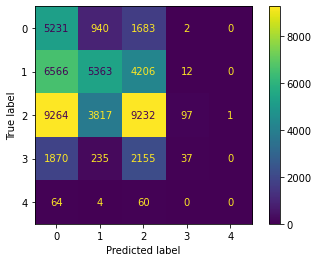

In [31]:
# Confusion Matrix for random forest base model
rf_val_cmatrix = plot_confusion_matrix(model_rf, X_val, y_val,)
rf_val_cmatrix;

In [45]:
print(classification_report(y_val, model_xgb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.20      0.74      0.31      7856
           1       0.54      0.32      0.40     16147
           2       0.57      0.29      0.39     22411
           3       0.67      0.00      0.00      4297
           4       0.00      0.00      0.00       128

    accuracy                           0.35     50839
   macro avg       0.39      0.27      0.22     50839
weighted avg       0.51      0.35      0.35     50839



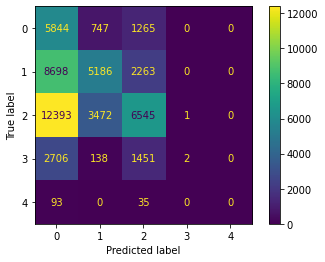

In [32]:
# Confusion Matrix for gradient boost base model
xgb_val_cmatrix = plot_confusion_matrix(model_xgb, X_val, y_val,)
xgb_val_cmatrix;

### cutoffs at 2012 and 2016

In [51]:
# Accuracy scores for random forest model
print(accuracy_score(y_train, model_rf.predict(X_train)))
print(accuracy_score(y_val, model_rf.predict(X_val)))

0.9907572389372522
0.38937927107061504


In [52]:
# Accuracy scores for gradient boost model
print(accuracy_score(y_train, model_xgb.predict(X_train)))
print(accuracy_score(y_val, model_xgb.predict(X_val)))

0.6211033616725211
0.3624715261958998


In [53]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.26      0.77      0.39      7594
           1       0.51      0.32      0.39     11240
           2       0.55      0.36      0.44     18912
           3       0.39      0.04      0.07      4274
           4       0.00      0.00      0.00       124

    accuracy                           0.39     42144
   macro avg       0.34      0.30      0.26     42144
weighted avg       0.47      0.39      0.38     42144



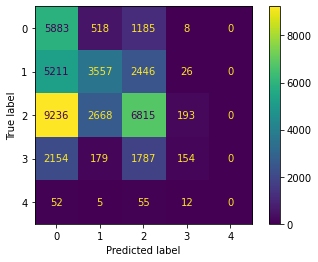

In [54]:
# Confusion Matrix for random forest base model
rf_val_cmatrix = plot_confusion_matrix(model_rf, X_val, y_val,)
rf_val_cmatrix;

In [55]:
print(classification_report(y_val, model_xgb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.24      0.79      0.37      7594
           1       0.53      0.32      0.40     11240
           2       0.56      0.30      0.39     18912
           3       0.45      0.02      0.03      4274
           4       0.00      0.00      0.00       124

    accuracy                           0.36     42144
   macro avg       0.36      0.28      0.24     42144
weighted avg       0.48      0.36      0.35     42144



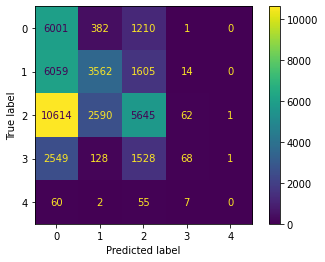

In [56]:
# Confusion Matrix for gradient boost base model
xgb_val_cmatrix = plot_confusion_matrix(model_xgb, X_val, y_val,)
xgb_val_cmatrix;

### cutoffs at 2014 and 2017

In [67]:
# Accuracy scores for random forest model
print(accuracy_score(y_train, model_rf.predict(X_train)))
print(accuracy_score(y_val, model_rf.predict(X_val)))

0.9904540287529254
0.40542428475976433


In [68]:
# Accuracy scores for gradient boost model
print(accuracy_score(y_train, model_xgb.predict(X_train)))
print(accuracy_score(y_val, model_xgb.predict(X_val)))

0.6199317953861585
0.36484844803498756


In [69]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.27      0.79      0.41      6041
           1       0.52      0.26      0.35      7417
           2       0.57      0.42      0.48     15317
           3       0.42      0.06      0.11      4036
           4       0.00      0.00      0.00       115

    accuracy                           0.41     32926
   macro avg       0.36      0.31      0.27     32926
weighted avg       0.49      0.41      0.39     32926



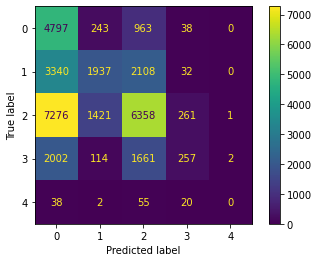

In [70]:
# Confusion Matrix for random forest base model
rf_val_cmatrix = plot_confusion_matrix(model_rf, X_val, y_val,)
rf_val_cmatrix;

In [71]:
print(classification_report(y_val, model_xgb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.24      0.82      0.37      6041
           1       0.54      0.28      0.37      7417
           2       0.59      0.32      0.41     15317
           3       0.36      0.03      0.06      4036
           4       0.00      0.00      0.00       115

    accuracy                           0.36     32926
   macro avg       0.35      0.29      0.24     32926
weighted avg       0.48      0.36      0.35     32926



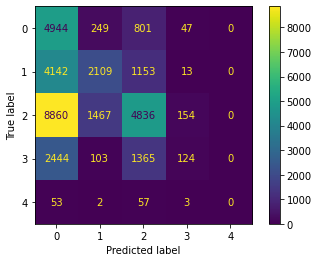

In [72]:
# Confusion Matrix for gradient boost base model
xgb_val_cmatrix = plot_confusion_matrix(model_xgb, X_val, y_val,)
xgb_val_cmatrix;

## Tune Model

### Permutation Importances (to negate features in wrangle)

In [73]:
# Calculate permutation importances
perm_imp = permutation_importance(
    model_xgb,
    X_val,
    y_val,
    n_repeats=8,
    n_jobs=-2,
    random_state=41)

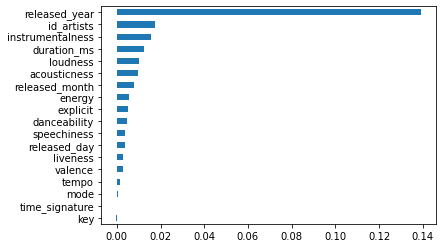

In [25]:
# # Plot the permutation importances

# # Create a data frame of the importances and feature names
# data = {'imp_mean': perm_imp['importances_mean'],
#         'imp_std': perm_imp['importances_std']}
# imp_df = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

# # Plot a bar chart
# imp_df['imp_mean'].plot(kind='barh');

In [33]:
# # Create a list of least important features to drop in
# # the wrangle function (copy and paste the list)
# imp_df[imp_df['imp_mean'] < 0.005].index

Index(['key', 'time_signature', 'mode', 'tempo', 'valence', 'liveness',
       'released_day', 'speechiness', 'danceability', 'explicit'],
      dtype='object')

### Permutation Importances (after changing to time series split)

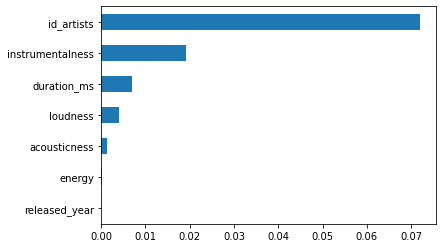

In [74]:
# Plot the permutation importances

# Create a data frame of the importances and feature names
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}
imp_df = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

# Plot a bar chart
imp_df['imp_mean'].plot(kind='barh');

### Hyper parameter tuning

In [75]:
# Do a randomized search to start the tuning process

# Setup empty results list
search_hist = []
best_searches = []

# Recall the pipeline(s)
model_xgb_ = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(random_state=73)
)

In [76]:
# Set a dictionary of the parameters to test
params = {
    'xgbclassifier__max_depth': np.arange(14, 40, 2),
    'xgbclassifier__n_estimators': np.arange(30, 160, 10),
    'xgbclassifier__learning_rate': np.arange(0.01, 0.11, 0.01),
    'xgbclassifier__gamma': np.arange(0.0, 1.1, 0.1),
    'xgbclassifier__reg_alpha': np.arange(0.0, 1.1, 0.1),
}

# Instatiate a RandomizedSearchCV model 
model_rs = RandomizedSearchCV(model_xgb_, params, n_iter=5, n_jobs=-4, verbose=3)

# Store some results to choose from and then run through the model at the top
model_rs.fit(X_, y_)
search_hist.append((model_rs.best_params_, model_rs.cv_results_))
best_searches.append((model_rs.best_params_, model_rs.best_score_))

# Compare results
print(model_rs.best_params_, model_rs.best_score_)
best_searches

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[16:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


NameError: name 'results' is not defined

In [78]:
search_hist.append((model_rs.best_params_, model_rs.cv_results_))
best_searches.append((model_rs.best_params_, model_rs.best_score_))

# Compare results
print(model_rs.best_params_, model_rs.best_score_)

{'xgbclassifier__reg_alpha': 0.30000000000000004, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_depth': 16, 'xgbclassifier__learning_rate': 0.09, 'xgbclassifier__gamma': 0.2} 0.3864157130666486


              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10802
           1       0.94      0.81      0.87      6027
           2       0.87      0.94      0.90     22484
           3       0.87      0.83      0.85     12801
           4       0.92      0.80      0.85       836

    accuracy                           0.89     52950
   macro avg       0.91      0.86      0.88     52950
weighted avg       0.90      0.89      0.89     52950



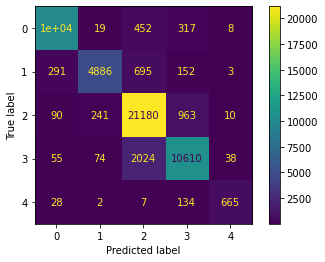

In [83]:
# Classiffication report
print(classification_report(y_test, model_rs.predict(X_test)))

# Confusion Matrix for gradient boost base model
rs_test_cmatrix = plot_confusion_matrix(model_rs, X_test, y_test,)
rs_test_cmatrix;

In [38]:
model_rs.best_params_, model_rs.best_score_

({'xgbclassifier__reg_alpha': 0.4,
  'xgbclassifier__n_estimators': 110,
  'xgbclassifier__max_depth': 26,
  'xgbclassifier__learning_rate': 0.09,
  'xgbclassifier__gamma': 0.4},
 0.5582979880369767)

In [40]:
model_rs.cv_results_

{'mean_fit_time': array([1181.61113362,  803.16211152, 1043.44583459,  497.23489552,
         753.97552624]),
 'std_fit_time': array([ 91.86653391,   9.57056267, 132.41723526,  51.0907859 ,
        109.77734393]),
 'mean_score_time': array([2.96042185, 2.68577647, 2.70327773, 1.36024008, 1.62893572]),
 'std_score_time': array([0.057003  , 0.16816728, 0.43352345, 0.12613424, 0.38274678]),
 'param_xgbclassifier__reg_alpha': masked_array(data=[0.6000000000000001, 0.2, 0.4, 1.0, 0.7000000000000001],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__n_estimators': masked_array(data=[120, 90, 110, 90, 80],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__max_depth': masked_array(data=[22, 22, 26, 16, 34],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifie

From include the test parameters from below when considering
final hyperparameter tuning. It seemed to score somewhat well.

In [29]:
## From accidental randomizedsearchCV on training set
# scored with validation set:

# model_rs.cv_results_

{'mean_fit_time': array([ 712.15494404, 1365.67333231,  609.66784658,  934.27336102,
         560.96044536]),
 'std_fit_time': array([42.76018003, 65.38483317, 41.57325728, 10.54832216, 24.05063566]),
 'mean_score_time': array([1.9699471 , 2.46703572, 1.55607495, 1.55967517, 1.48276172]),
 'std_score_time': array([0.05425379, 0.24993397, 0.41168213, 0.09744813, 0.12345933]),
 'param_xgbclassifier__reg_alpha': masked_array(data=[0.1, 0.4, 0.9, 0.2, 0.9],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__n_estimators': masked_array(data=[60, 150, 50, 130, 50],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__max_depth': masked_array(data=[32, 24, 36, 24, 32],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__learning_rate': masked_array(data=[0.099

## Communicate Results

I didn't realize that for a classification problem the pd plot would look this way, but it makes sense that it's representing the relationship in each class.

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and incr

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and incr

(<Figure size 1080x1764 with 11 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': [<AxesSubplot:xlabel='released_year (class 0)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 1)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 2)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 3)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 4)', ylabel='instrumentalness'>]})

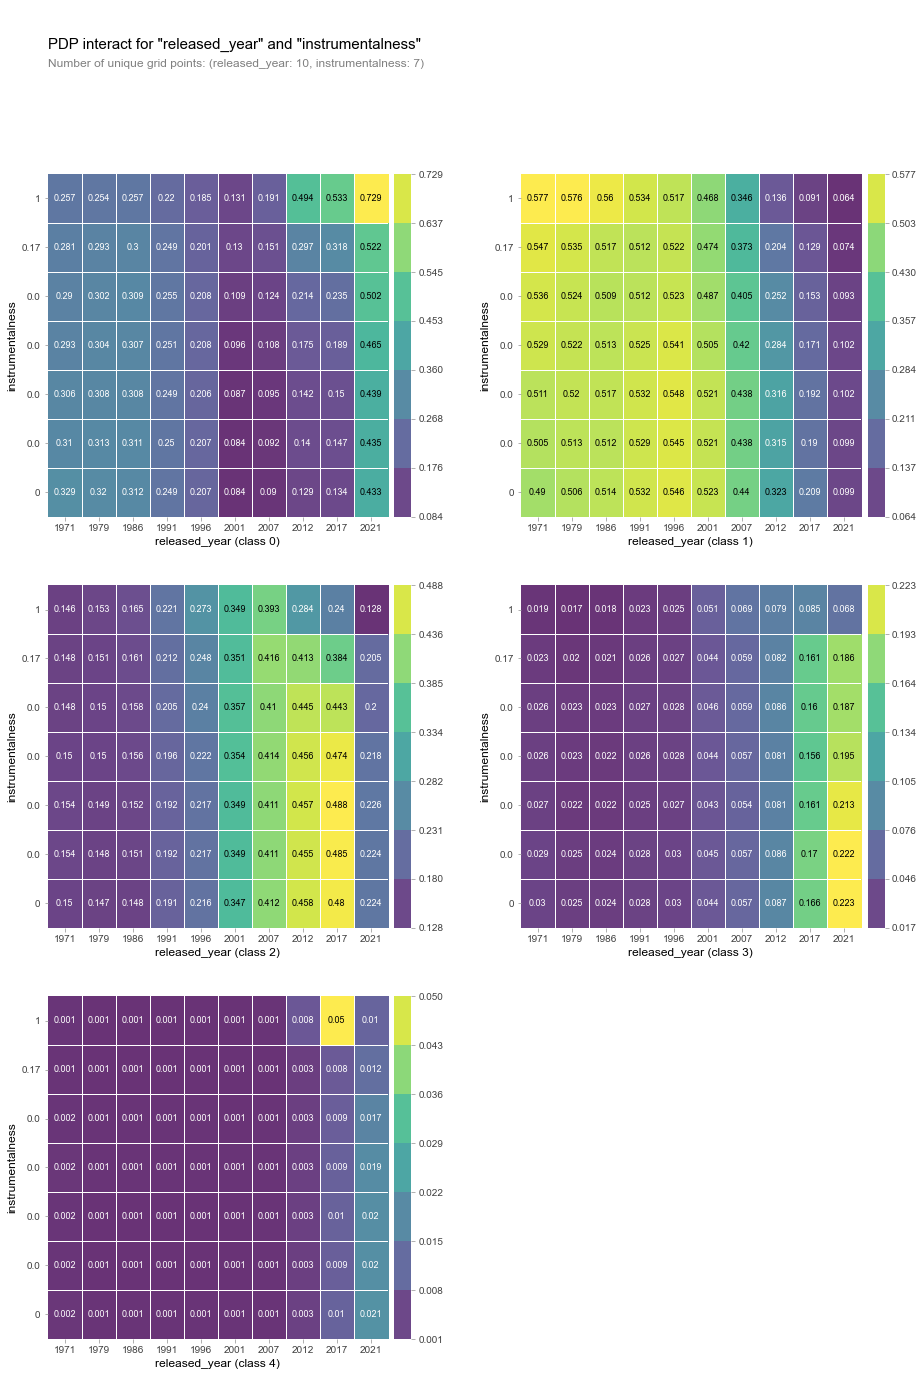

In [29]:
# Make a partial dependecy plot for the top 2 features

# Store the features in an appropriate variable
features = ['released_year', 'instrumentalness']
# Instantiate pdp_interact
interact = pdp_interact(
    model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

# Plot
pdp_interact_plot(interact, plot_type='grid', feature_names=features)

In [ ]:
# Make a Shaply force plot

# Select an observation
row = X_val.head(1)

explainer = shap.TreeExplainer(####) #Since I'm not to use a pipeline here, I'll have to preprocess the data sets and make a new model to go here.
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)